# **U-Net 이미지 분할**
이미지 분할은 이미지에서 어떤 픽셀이 어떤 객체에 속하는지 판별하는 방법을 배웁니다.

**Oxford-IIIT Pets 데이터 세트**

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.8MB 20.4MB/s 


In [29]:
import tensorflow as tf
import numpy as np

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

#tfds는 mnist,fashion mnist와 같이 텐서플로우에 기본적으로 들어가있는 데이터세트를 텐서플로우의 Dataset로 바로 바꿔사용할수 있게해준다.
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
#oxford_iiit_pet v3로드
#with_info:True일 경우 이 데이터 세트의 정보를 tfds.core.DatasetInfo자료형으로 인자를 반환한다.
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
print(info)
#oxford_iiit_pet 3.2.0
#oxford_iiit_pet 데이터세트는 (이미지,라벨)의 key-value형태로 구성
#라벨은 각 이미지의 각 픽셀마다 붙어있으며, 1이면 객체에 속한 픽셀, 2이면 객체 주변 픽셀, 3이면 객체에 속하지 않은 픽셀을 나타낸다.

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_ex

In [6]:
#인풋 이미지와 레이블을 받아 표준화하는 함수 정의
def normalize(input_image, input_mask):
  #이미지 표준화
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #레이블 표준화
  #oxford_iiit_pet 데이터세트는 레이블이 [1,2,3]으로 되어있으며 텐서플로우 모델이 원하는건 0부터 라벨링된 데이터이기 때문에 1을 빼서 표준화 한다.
  input_mask -= 1
  return input_image, input_mask

In [7]:
#학습 데이터세트를 받아 변형하여 데이터 개수를 늘이는 등의 작업을하는 학습 데이터 입력 파이프라인 함수를 텐서플로우 함수로 정의
@tf.function
def load_image_train(datapoint):
  #학습데이터의 이미지를 128*128로 랜더링
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  #각 픽셀마다 있는 레이블의 집합 이미지(마스크)를 128*128로 랜더링
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  #50%확률로 이미지와 마스크 좌우반전
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  #이미지 표준화
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
#테스트 데이터세트를 받아 변형하여 데이터 개수를 늘이는 작업등을 하는 테스트 데이터 입력 파이프라인 함수를 정의
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  #테스트 데이터세트는 학습할 용도가 아니므로 좌우반전등의 변형이 필요없다.

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
#DatasetInfo의 splits메서드는 주어진 Info의 splits 정보를 (String(key),SplitInfo(SplitInfo))의 key-value형으로 반환한다.
print(info.splits['train'])
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

<SplitInfo num_examples=3680, num_shards=4>


In [10]:
#각 이미지와 마스크를 매핑
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [11]:
#텐서플로우 데이터세트는 데이터의 집합 뿐만 아니라 이 데이터를 학습할때 파이프라인에 대한 정보까지 담고있다.
#아래는 훈련데이터세트의 파이프라인을 정의한다.

#dataset의 cache(path)는 path에 데이터 세트의 캐시파일을 저장합니다. 이 캐시파일은 나중에 데이터세트를 불러올때 참조합니다. path가 주어지지않으면 메모리에 캐시를 저장합니다.
#cache메소드는 return값으로 캐시와 연결된 데이터세트를 반환합니다.
#repeat메소드는 이 데이터를 몇번 불러올지 정한다.
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(128, 128, 3)


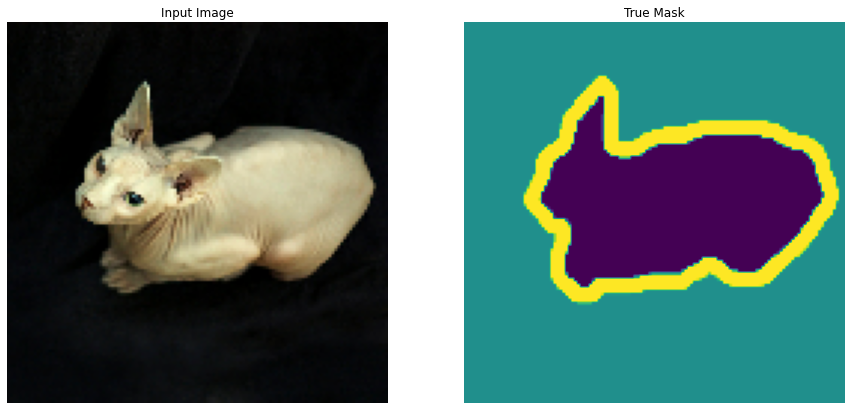

In [13]:
#take(n)메소드는 데이터세트의 배치를 n번 불러온다.
#아래처럼 배치를 한번불러오면 설정해놓은 BATCHSIZE로 인해 이미지 하나만 불러와진다.
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
  print(image.shape)
display([sample_image, sample_mask])

**모델 정의하기**

> U-Net은 샘플을 축소하는 DownSample모델과 축소된 샘플을 다시 복원하는 UpSample모델로 구성된다.

https://m.blog.naver.com/9709193/221979612209







In [14]:
#출력 채널의 수
#판별해야하는 3개의 클래스(마스크의 [0,1,2])가 있기때문에 3으로 정한다.
OUTPUT_CHANNELS = 3

In [15]:
#DownSample모델은 MobileNetV2모델중 추출해서 사용한다.

#사전에 훈련되어있는 U-Net 인코더 모델 MobileNetV2를 사용한다.
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
#MobileNetV2모델의 층들중 사용할 층을 미리 선언
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
#선언한 층들 추출
layers = [base_model.get_layer(name).output for name in layer_names]
#모델 생성
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
#사전에 훈련되어있는 MobileNetV2를 사용하기에 다운샘플 모델은 훈련하지 않습니다.
down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [16]:
#UpSameple모델은 pix2pix모델의 upsample모델을 사용한다.
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [39]:
#U-Net모델 구성
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 모델을 통해 다운샘플링합시다
  skips = down_stack(x)
  #리스트에 -1을 집어넣으면 그 리스트의 마지막 항목을 들고온다.
  #skips는 각 다운 샘플 레이어의 출력값의 배열이므로 아래의 코드는 마지막 다운샘플 층의 출력만 추출해 저장하겠다는 의미이다.
  x = skips[-1]
  #마지막 항목을 제외하고 역순으로 다운샘플을 정렬한다.
  #이러면 5개의 출력값이 아닌 마지막 층 제외 4개의 출력값으로 줄어든다.
  skips = reversed(skips[:-1])

  #건너뛰기 연결을 업샘플링하고 설정하세요
  #업샘플링 모델의 리스트와 skips를 up과 skip으로 각각 순회
  for up, skip in zip(up_stack, skips):
    x = up(x)
    #tf.keras.layers.Concatenate레이어는 두 텐서를 차원이 다르더라도 zip함수 처럼 묶어준다.
    #https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate
    concat = tf.keras.layers.Concatenate()
    #업샘플링한 x와 skip은 둘다 8*8의 이미지 이므로 둘을 합쳐 새로운 8*8의 이미지를 생성한다.
    x = concat([x, skip])

  # 이 모델의 마지막 층입니다
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [41]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              #라벨이 원-핫 인코딩 되어있지 않기 때문에 다중분류 손실함수로 SparseCategoricalCrossentropy를 사용한다.
              #또한 분류문제 이므로 로지스트 함수를 베이스로 사용한다.
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

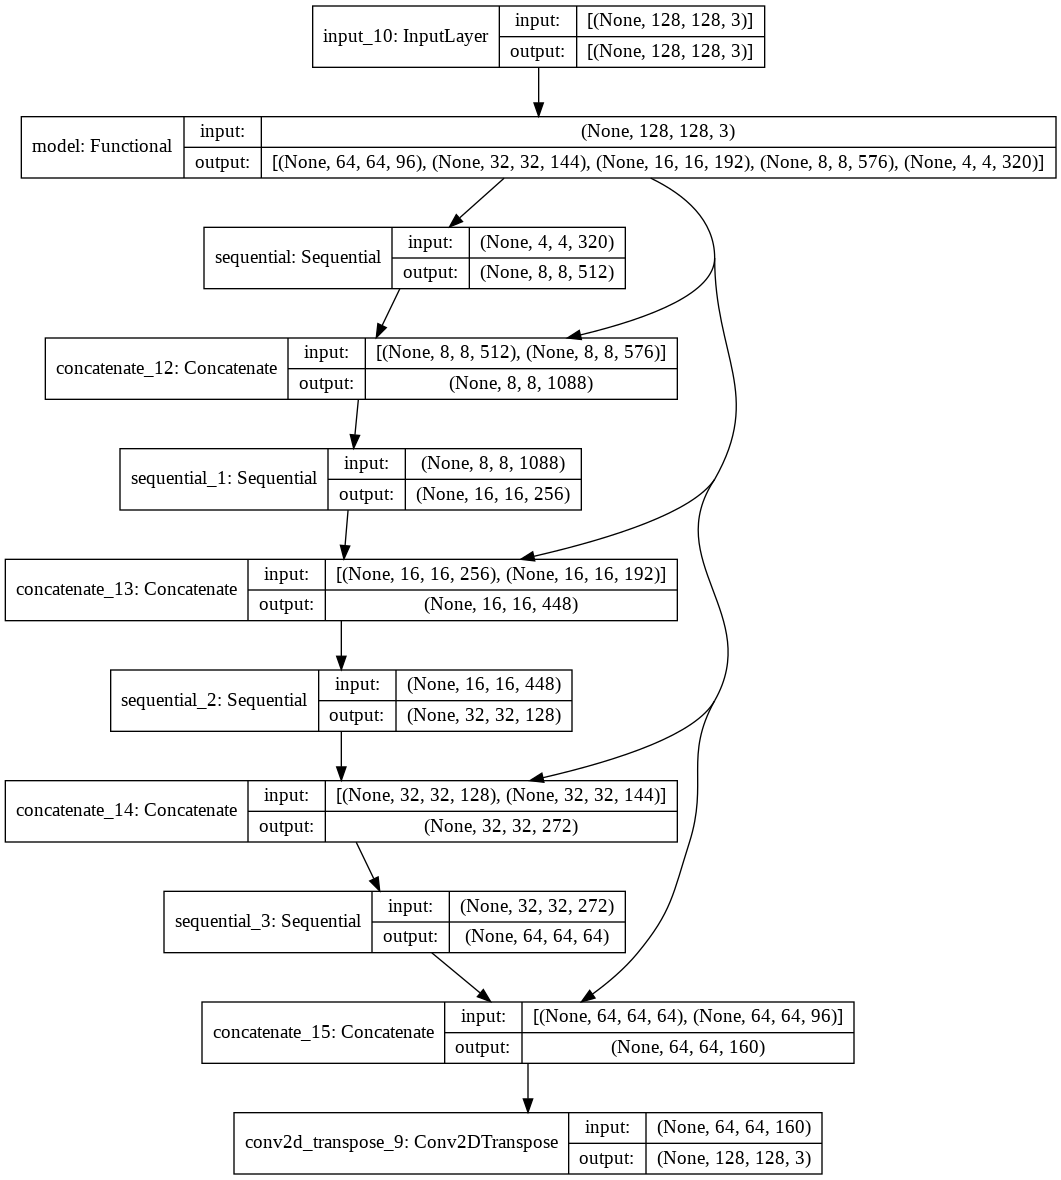

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [45]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  #tf.newaxis는 새로운 차원을 추가해준다.
  #reshape과 비슷한 용도로 사용
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [46]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

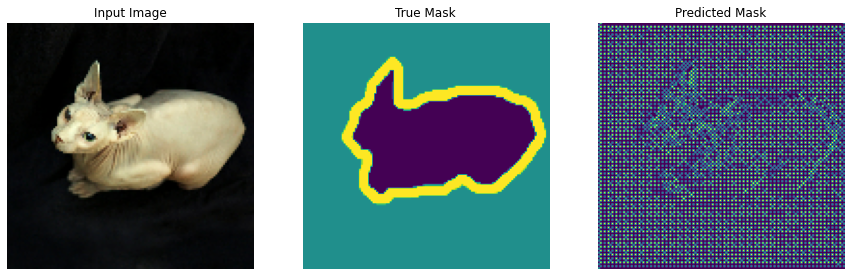

In [47]:
#아무런 훈련 없이 예측
show_predictions()

In [48]:
#모델이 학습되는 동안 이미지를 표시해줄 콜백
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

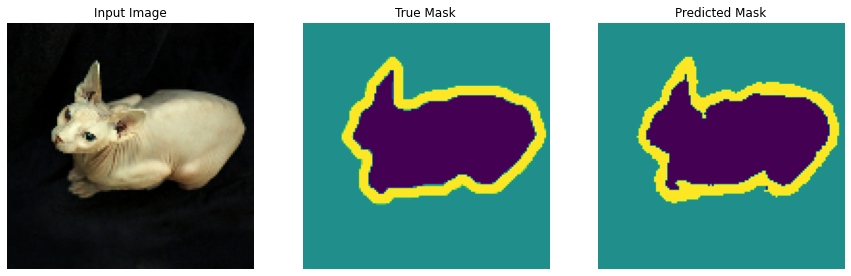


에포크 이후 예측 예시 20



In [49]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

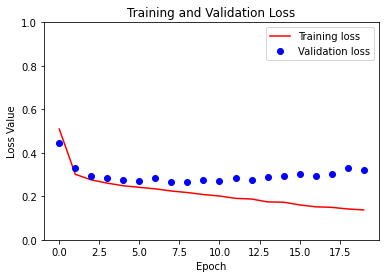

In [50]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

**예측하기**

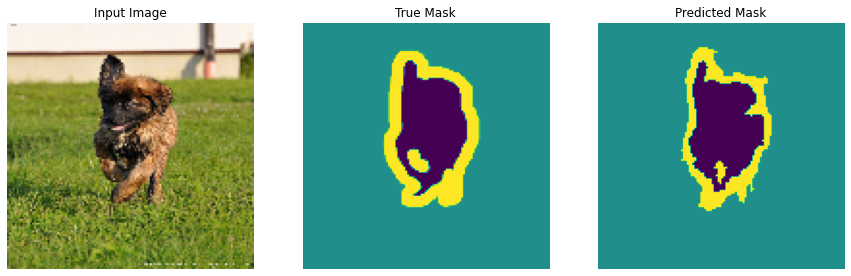

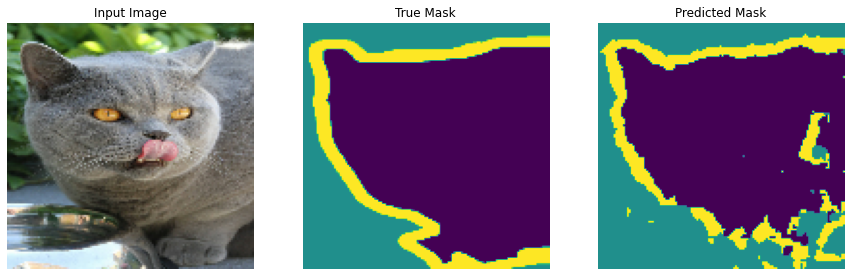

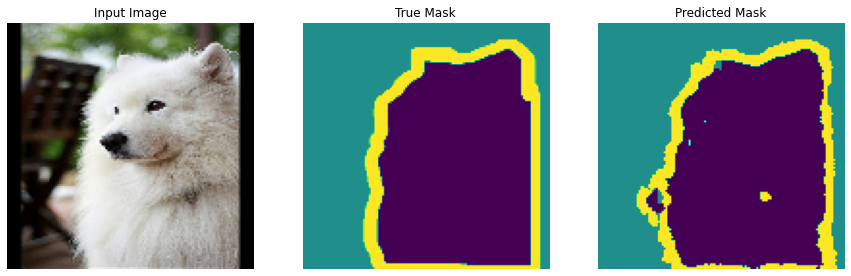

In [51]:
show_predictions(test_dataset, 3)